In [1]:
import matplotlib.pyplot as plt
from models import *
from train import *
from dataset import *


In [2]:
train_loader, test_loader, classes = load_cifar10()

In [3]:
# Instantiate the models
model_ln = ResNetLN()
model_dyt = ResNetDyT()

# Initialize the models with the same weights
def init_weights(m, init_type):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        if init_type == 'kaiming':
            nn.init.kaiming_normal_(m.weight)
        elif init_type == 'xavier':
            nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.01)

# Initialize the models with the same weights
weights_init = lambda m: init_weights(m, 'kaiming')

model_ln.apply(weights_init)
model_dyt.apply(weights_init)


ResNetDyT(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (dyt1): DyT()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (dyt2): DyT()
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (dyt3): DyT()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (dyt4): DyT()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [4]:
# check if the models have the same weights
def check_weights(model1, model2):
    layer = 0
    # get layer names for each model
    layers1 = [name for name, _ in model1.named_parameters()]
    layers2 = [name for name, _ in model2.named_parameters()]
    # check if the layers are the same
    for m1, m2 in zip(model1.parameters(), model2.parameters()):
        if layers1[layer] != layers2[layer]:
            if "ln" in layers1[layer] or "ln" in layers2[layer]:
                # layernorm can and should differ because it is
                # exchanged with the dynamic tanh
                continue
            print('Layer', layer, 'names are not equal')
            print(layers1[layer], layers2[layer])
            continue
        if not torch.equal(m1, m2):
            print('Layer', layer, 'weights are not equal')
            print(layers1[layer], layers2[layer])
            return False
        layer += 1
    return True

print(check_weights(model_ln, model_dyt))

Layer 0 weights are not equal
conv1.weight conv1.weight
False


In [5]:
# Sample input data: a single 3-channel 32x32 image
input_data = torch.randn(128, 3, 32, 32)
# Forward pass to collect data
output_ln_init, ln_data_init = model_ln(input_data)
output_dyt_init, dyt_data_init = model_dyt(input_data)

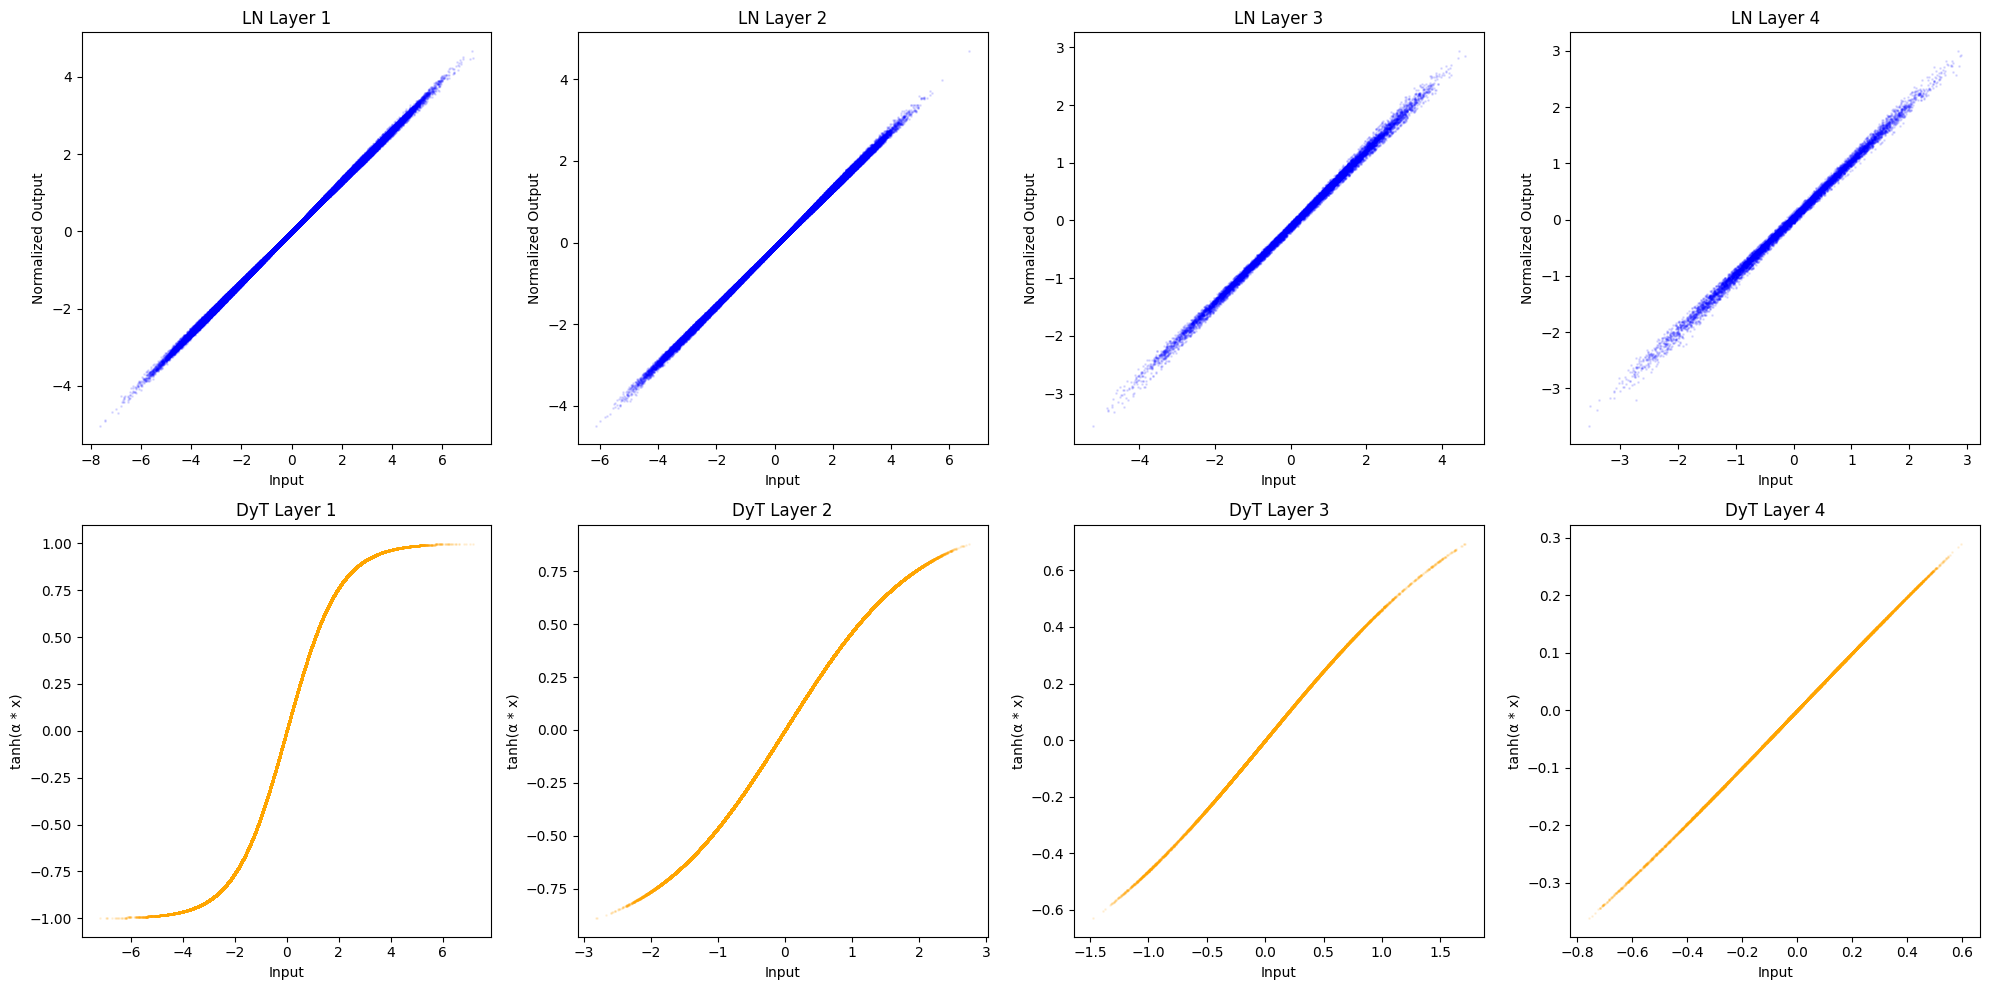

In [6]:
# Create a 2x4 subplot grid
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i in range(4):
    # LN layer visualization
    x_ln, normalized_ln = ln_data_init[i]
    x_ln_flat = x_ln.flatten().detach().cpu().numpy()
    normalized_ln_flat = normalized_ln.flatten().detach().cpu().numpy()
    axes[0, i].scatter(x_ln_flat, normalized_ln_flat, alpha=0.1, s=1, color='blue')
    axes[0, i].set_title(f'LN Layer {i+1}')
    axes[0, i].set_xlabel('Input')
    axes[0, i].set_ylabel('Normalized Output')

    # DyT layer visualization
    x_dyt, tanh_dyt = dyt_data_init[i]
    x_dyt_flat = x_dyt.flatten().detach().cpu().numpy()
    tanh_dyt_flat = tanh_dyt.flatten().detach().cpu().numpy()
    axes[1, i].scatter(x_dyt_flat, tanh_dyt_flat, alpha=0.1, s=1, color='orange')
    axes[1, i].set_title(f'DyT Layer {i+1}')
    axes[1, i].set_xlabel('Input')
    axes[1, i].set_ylabel('tanh(α * x)')

# Adjust layout and display
plt.tight_layout()
plt.show()

In [7]:
#optim
from torch import optim
# cross entropy loss
criterion = nn.CrossEntropyLoss()

In [8]:
optimizer_ln = optim.Adam(model_ln.parameters(), lr=0.001)
optimizer_dyt = optim.Adam(model_dyt.parameters(), lr=0.001)

In [ ]:
# compare the two models
epoch_train_loss_ln = []
epoch_train_loss_dyt = []
epoch_test_loss_ln = []
epoch_test_loss_dyt = []
epoch_test_acc_ln = []
epoch_test_acc_dyt = []

for epoch in range(1, 100):
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer_ln.zero_grad()
        optimizer_dyt.zero_grad()

        # forward + backward + optimize
        outputs_ln, _ = model_ln(inputs)
        loss_ln = criterion(outputs_ln, labels)
        loss_ln.backward()
        optimizer_ln.step()

        outputs_dyt, _ = model_dyt(inputs)
        loss_dyt = criterion(outputs_dyt, labels)
        loss_dyt.backward()
        optimizer_dyt.step()

        # print statistics
        if i % 2000 == 1999:
            print(f'[{epoch}, {i + 1}] loss_ln: {loss_ln.item()}, loss_dyt: {loss_dyt.item()}')

    epoch_train_loss_ln.append(loss_ln.item())
    epoch_train_loss_dyt.append(loss_dyt.item())

    for i, data in enumerate(test_loader, 0):
        inputs, labels = data
        outputs_ln, _ = model_ln(inputs)
        loss_ln = criterion(outputs_ln, labels)
        outputs_dyt, _ = model_dyt(inputs)
        loss_dyt = criterion(outputs_dyt, labels)

        if i % 2000 == 1999:
            print(f'[{epoch}, {i + 1}] test_loss_ln: {loss_ln.item()}, test_loss_dyt: {loss_dyt.item()}')

    epoch_test_loss_ln.append(loss_ln.item())
    epoch_test_loss_dyt.append(loss_dyt.item())
    #epoch_test_acc_ln.append(evaluate(model_ln, test_loader))
    #epoch_test_acc_dyt.append(evaluate(model_dyt, test_loader))

[1, 2000] loss_ln: 1.826136827468872, loss_dyt: 1.8248380422592163
[1, 4000] loss_ln: 1.3823461532592773, loss_dyt: 1.4886491298675537
[1, 6000] loss_ln: 1.9914436340332031, loss_dyt: 1.6785141229629517


In [ ]:
#TODO : random seed (generator)
#TODO : init model with the same weights
#TODO : both models should train with the same data
#TODO : compare the results

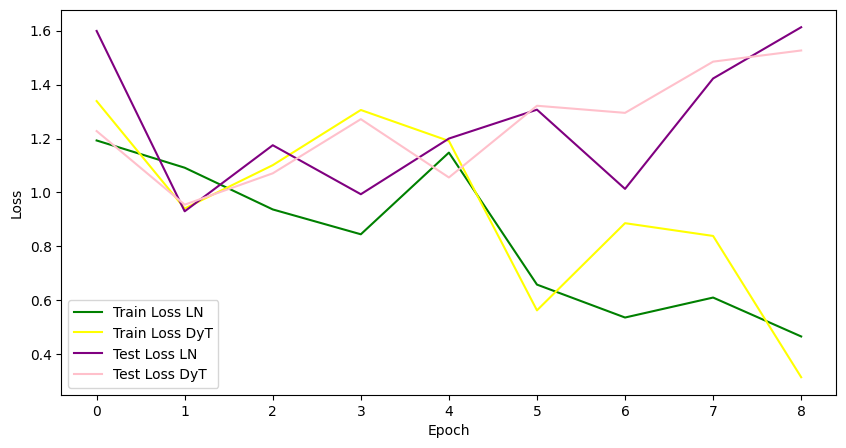

In [ ]:
# plot loss curves
plt.figure(figsize=(10, 5))

plt.plot(epoch_train_loss_ln, label='Train Loss LN', color='green')
plt.plot(epoch_train_loss_dyt, label='Train Loss DyT', color='yellow')
plt.plot(epoch_test_loss_ln, label='Test Loss LN', color='purple')
plt.plot(epoch_test_loss_dyt, label='Test Loss DyT', color='pink')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, 100)), y=epoch_train_loss_ln, mode='lines', name='Train Loss LN'))
fig.add_trace(go.Scatter(x=list(range(1, 100)), y=epoch_train_loss_dyt, mode='lines', name='Train Loss DyT'))
fig.add_trace(go.Scatter(x=list(range(1, 100)), y=epoch_test_loss_ln, mode='lines', name='Test Loss LN'))
fig.add_trace(go.Scatter(x=list(range(1, 100)), y=epoch_test_loss_dyt, mode='lines', name='Test Loss DyT'))

fig.update_layout(title='Loss Curves',
                    xaxis_title='Epoch',
                    yaxis_title='Loss')
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

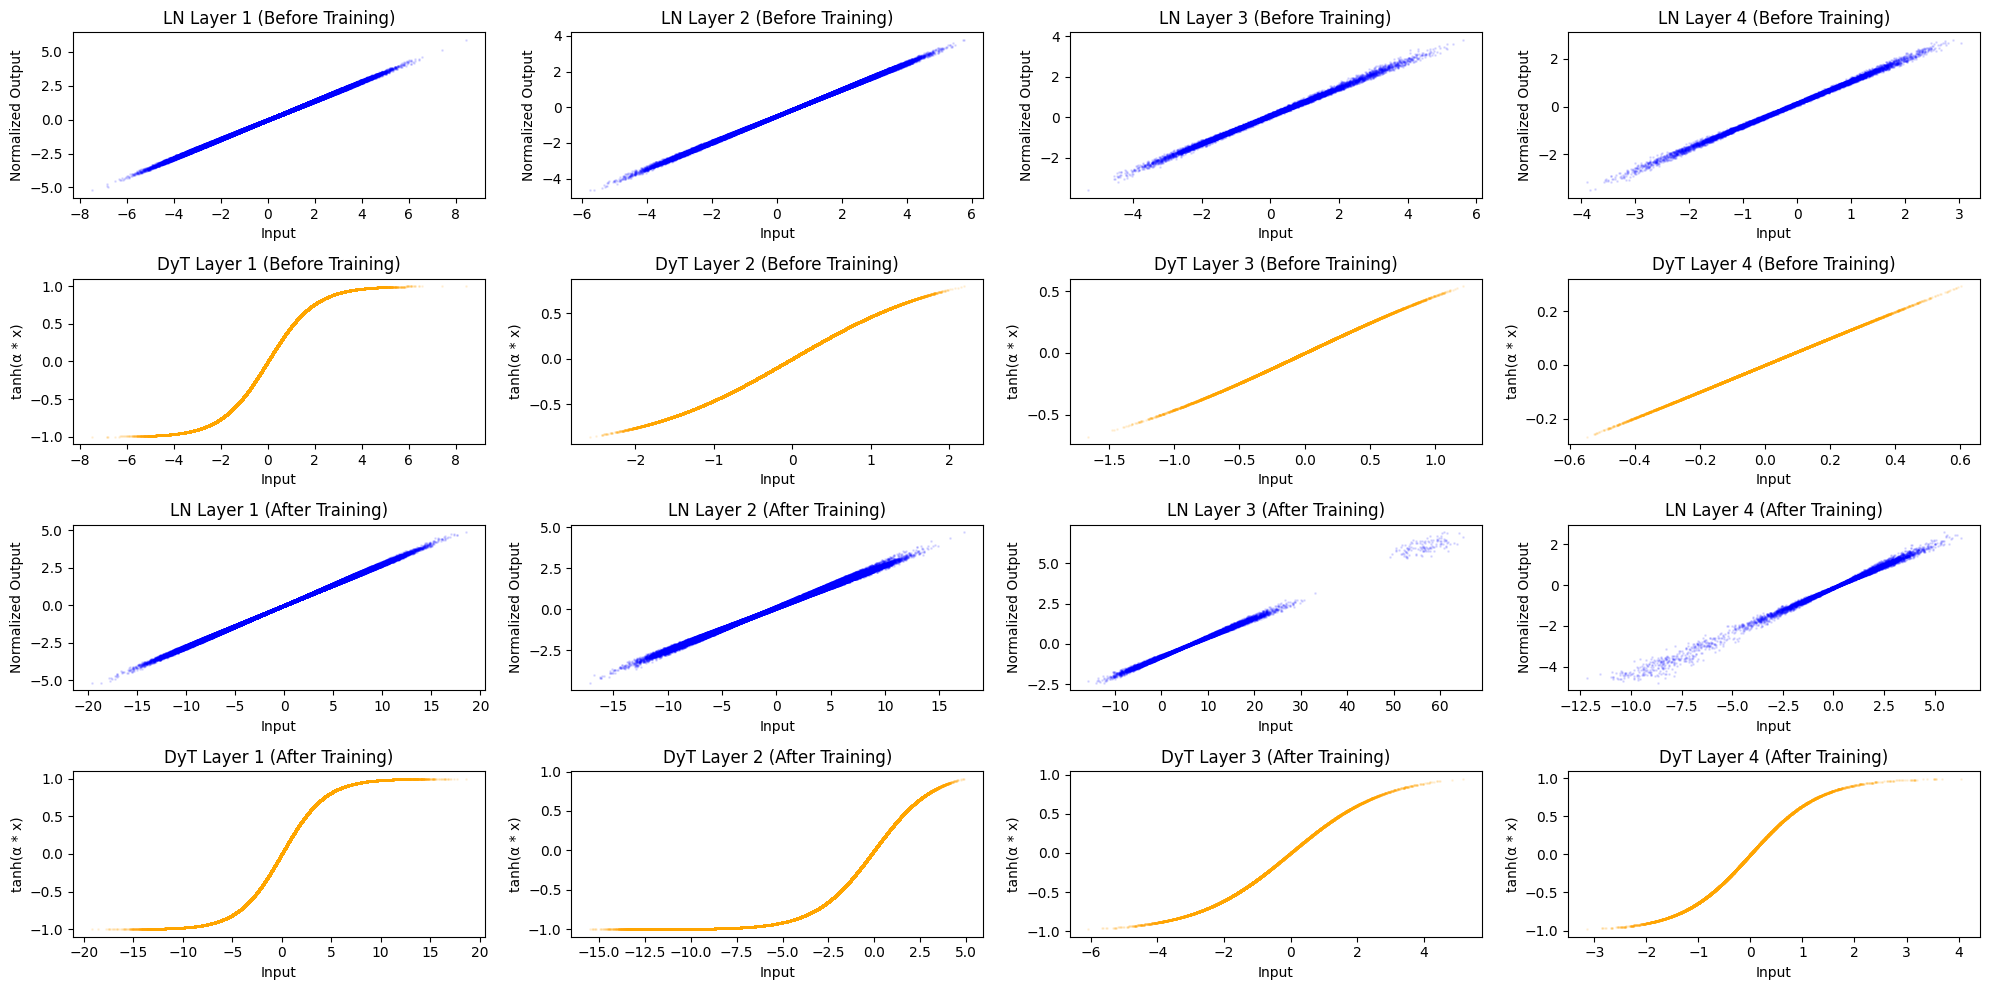

In [ ]:
# Forward pass to collect data
output_ln, ln_data = model_ln(input_data)
output_dyt, dyt_data = model_dyt(input_data)

# Create a 4x4 subplot grid
fig, axes = plt.subplots(4, 4, figsize=(20, 10))

# Plot the data before and after training

for i in range(4):
    # LN layer visualization
    x_ln, normalized_ln = ln_data_init[i]
    x_ln_flat = x_ln.flatten().detach().cpu().numpy()
    normalized_ln_flat = normalized_ln.flatten().detach().cpu().numpy()
    axes[0, i].scatter(x_ln_flat, normalized_ln_flat, alpha=0.1, s=1, color='blue')
    axes[0, i].set_title(f'LN Layer {i+1} (Before Training)')
    axes[0, i].set_xlabel('Input')
    axes[0, i].set_ylabel('Normalized Output')

    # DyT layer visualization
    x_dyt, tanh_dyt = dyt_data_init[i]
    x_dyt_flat = x_dyt.flatten().detach().cpu().numpy()
    tanh_dyt_flat = tanh_dyt.flatten().detach().cpu().numpy()
    axes[1, i].scatter(x_dyt_flat, tanh_dyt_flat, alpha=0.1, s=1, color='orange')
    axes[1, i].set_title(f'DyT Layer {i+1} (Before Training)')
    axes[1, i].set_xlabel('Input')
    axes[1, i].set_ylabel('tanh(α * x)')

    # LN layer visualization
    x_ln, normalized_ln = ln_data[i]
    x_ln_flat = x_ln.flatten().detach().cpu().numpy()
    normalized_ln_flat = normalized_ln.flatten().detach().cpu().numpy()
    axes[2, i].scatter(x_ln_flat, normalized_ln_flat, alpha=0.1, s=1, color='blue')


    axes[2, i].set_title(f'LN Layer {i+1} (After Training)')
    axes[2, i].set_xlabel('Input')
    axes[2, i].set_ylabel('Normalized Output')

    # DyT layer visualization
    x_dyt, tanh_dyt = dyt_data[i]
    x_dyt_flat = x_dyt.flatten().detach().cpu().numpy()
    tanh_dyt_flat = tanh_dyt.flatten().detach().cpu().numpy()
    axes[3, i].scatter(x_dyt_flat, tanh_dyt_flat, alpha=0.1, s=1, color='orange')
    axes[3, i].set_title(f'DyT Layer {i+1} (After Training)')
    axes[3, i].set_xlabel('Input')
    axes[3, i].set_ylabel('tanh(α * x)')

# Adjust layout and display
plt.tight_layout()
plt.show()
